In [4]:
import monai
import gc
import torch
from utils import plot_3d_image
import os

In [238]:
def load_scan(path):
    """
    Load and preprocess a CT scan from a file path or uploaded file.

    Args:
        path (str or UploadedFile): The file path or uploaded file object of the CT scan.

    Returns:
        dict: A dictionary containing the preprocessed CT scan image tensor with key "image".
              Returns None if the input path is None.
    """
    if path is None:
        return None
    
    # Define the preprocessing transforms
    transforms = monai.transforms.Compose([
        monai.transforms.LoadImaged(keys=["image"], ensure_channel_first=True),
        monai.transforms.EnsureTyped(keys=["image"]),
        monai.transforms.Orientationd(keys=["image"], axcodes="SPL"),
        monai.transforms.Spacingd(keys=["image"], pixdim=[3,1,1], mode="bilinear"),
        monai.transforms.CropForegroundd(keys=["image"], source_key="image"),
        monai.transforms.ScaleIntensityRanged(keys="image", a_min=-1024, a_max=2048, b_min=0, b_max=1, clip=True),
        monai.transforms.Lambda(func=lambda x: x["image"].as_tensor())
    ])

    # Load and preprocess the scan
    data = {"image": path}
    image = transforms(data)
    return {"image": image}

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import rgb_to_hsv

def lab_to_rgb(lab):
    # Convert Lab to XYZ
    L, a, b = lab[0], lab[1], lab[2]
    
    fy = (L + 16) / 116
    fx = a / 500 + fy
    fz = fy - b / 200

    xyz_ref = torch.tensor([0.95047, 1.0, 1.08883]).to(lab.device)
    
    mask = (fx ** 3 > 0.008856).float()
    x = mask * (fx ** 3) * xyz_ref[0] + (1 - mask) * ((116 * fx - 16) / 903.3) * xyz_ref[0]
    
    mask = (fy ** 3 > 0.008856).float()
    y = mask * (fy ** 3) * xyz_ref[1] + (1 - mask) * ((L) / 903.3) * xyz_ref[1]
    
    mask = (fz ** 3 > 0.008856).float()
    z = mask * (fz ** 3) * xyz_ref[2] + (1 - mask) * ((116 * fz - 16) / 903.3) * xyz_ref[2]

    # Convert XYZ to RGB
    r =  3.2404542 * x - 1.5371385 * y - 0.4985314 * z
    g = -0.9692660 * x + 1.8760108 * y + 0.0415560 * z
    b =  0.0556434 * x - 0.2040259 * y + 1.0572252 * z

    # Clip values to [0, 1] range
    rgb = torch.stack([r, g, b], dim=0).clamp(0, 1)

    # Apply gamma correction
    mask = (rgb > 0.0031308).float()
    rgb = mask * (1.055 * (rgb ** (1 / 2.4)) - 0.055) + (1 - mask) * (12.92 * rgb)

    return rgb


In [5]:
import torch
import os
from monai.networks.nets import SegResNetDS
from lighter.utils.model import adjust_prefix_and_load_state_dict

# Wrap the segresnet model in a module that returns the embeddings
class EmbeddingModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.model = adjust_prefix_and_load_state_dict(
                    ckpt_path="/mnt/data1/CT_FM/latest_fm_checkpoints/original/epoch=449-step=225000-v1.ckpt",
                    ckpt_to_model_prefix={"backbone." : "encoder"},
                    model=SegResNetDS(
                        spatial_dims=3,
                        in_channels=1,
                        out_channels=1,
                        init_filters=32,
                        blocks_down=[1, 2, 2, 4, 4],
                        dsdepth=4
                    )
            )


    def forward(self, x):
        x = self.model.encoder(x)
        x.reverse()
        x = x.pop(0)
        return x
    
def load_model():
    model = EmbeddingModel()
    model.to(torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"))
    model.eval()
    return model

In [239]:
image_dict_list = [load_scan("/home/suraj/Repositories/lighter-ct-fm/semantic-search-app/assets/scans/s0114.nii.gz"),
                   load_scan("/home/suraj/Repositories/lighter-ct-fm/semantic-search-app/assets/scans/s0146.nii.gz")]


monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.


In [5]:
class IterableDataset(torch.utils.data.IterableDataset):
    def __init__(self, generator):
        self.generator = generator

    def __iter__(self):
        return self.generator

In [6]:
patch_size = (24,64,64)

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
predictor = load_model()
predictor = predictor.to("cuda:0")
image = image_dict_list[1]["image"]
image = image.to("cuda:0").unsqueeze(0)

splitter = monai.inferers.SlidingWindowSplitter(patch_size, overlap=0.75)
dataset = IterableDataset(splitter(image))
patch_dataloader = torch.utils.data.DataLoader(dataset, batch_size=8)
concept_map = torch.zeros(1, 512, *image.shape[2:], device=torch.device("cpu"))

In [7]:
import gc
from tqdm import tqdm

with torch.no_grad():
    for patches, locations in tqdm(patch_dataloader):
        upsampled_patches = torch.nn.functional.interpolate(patches.squeeze(1), scale_factor=(8, 4, 4))
        preds = predictor(upsampled_patches)
        preds = preds.squeeze().cpu()
        preds = torch.nn.functional.interpolate(preds, size=(24, 64, 64), mode='trilinear', align_corners=False)
        torch.cuda.empty_cache()
        gc.collect()
        # Create a Gaussian kernel for weighted averaging
        def gaussian_kernel(size, sigma):
            coords = torch.arange(
                start=-(size - 1) / 2.0, end=(size - 1) / 2.0 + 1, dtype=torch.float,
            )

            kernel = torch.exp(-(coords**2) / (2 * sigma**2))
            return kernel

        kernel_z = gaussian_kernel(patch_size[0], sigma=patch_size[0]*0.5).to(preds.device)
        kernel_y = gaussian_kernel(patch_size[1], sigma=patch_size[1]*0.5).to(preds.device)
        kernel_x = gaussian_kernel(patch_size[2], sigma=patch_size[2]*0.5).to(preds.device)
        weight = kernel_z[:, None, None] * kernel_y[None, :, None] * kernel_x[None, None, :]
        min_non_zero = max(torch.min(weight).item(), 1e-3)
        weight = torch.clamp_(weight, min=min_non_zero)


        for z, y, x, pred in zip(locations[0], locations[1], locations[2], preds):
            z_start, y_start, x_start = z.item(), y.item(), x.item()
            z_end, y_end, x_end = z_start + patch_size[0], y_start + patch_size[1], x_start + patch_size[2]
            
            # Ensure we don't exceed the concept_map dimensions
            z_end = min(z_end, concept_map.shape[2])
            y_end = min(y_end, concept_map.shape[3])
            x_end = min(x_end, concept_map.shape[4])
            
            # Adjust pred and weight sizes to match the target region
            pred_z, pred_y, pred_x = z_end - z_start, y_end - y_start, x_end - x_start
            pred_adjusted = pred[:, :pred_z, :pred_y, :pred_x]
            weight_adjusted = weight[:pred_z, :pred_y, :pred_x]

            
            # Apply Gaussian weighted averaging
            concept_map[0, :, z_start:z_end, y_start:y_end, x_start:x_end] += pred_adjusted * weight_adjusted

501it [40:27,  4.84s/it]


# Run PCA calculation in meta concept PCA script


In [6]:
import torch
from utils import plot_3d_image
import numpy as np
from sklearn.decomposition import PCA
import argparse
import gc

def apply_pca(concept_map, n_components=4):
    print("Applying PCA to concept maps of shape:", concept_map.shape)
    concept_map_reshaped = concept_map.view(concept_map.shape[1], -1).T
    concept_map_reshaped -= torch.mean(concept_map_reshaped, dim=0)
    concept_map_reshaped /= torch.std(concept_map_reshaped, dim=0)
    print("Shape of PCA input:", concept_map_reshaped.shape)
    pca = PCA(n_components=n_components, random_state=42)
    concept_map_pca = pca.fit_transform(concept_map_reshaped.numpy())
    concept_map_pca = concept_map_pca.T.reshape(n_components, concept_map.shape[0], *concept_map.shape[2:])
    return concept_map_pca, pca



In [7]:
input_files = ["/home/suraj/Repositories/lighter-ct-fm/notebooks/concept_map_s0114.torch",
               "/home/suraj/Repositories/lighter-ct-fm/notebooks/concept_map_s0146.torch"]
concept_maps = [torch.load(file) for file in input_files]
interp = lambda x: torch.nn.functional.interpolate(x, size=(300, 300, 300), mode='trilinear', align_corners=False)
concept_maps = [interp(concept_map) for concept_map in concept_maps]
gc.collect()
concept_maps = torch.cat(concept_maps, dim=0)
concept_map_pca, pca = apply_pca(concept_maps, n_components=4)

Applying PCA to concept maps of shape: torch.Size([2, 512, 300, 300, 300])
Shape of PCA input: torch.Size([54000000, 512])


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


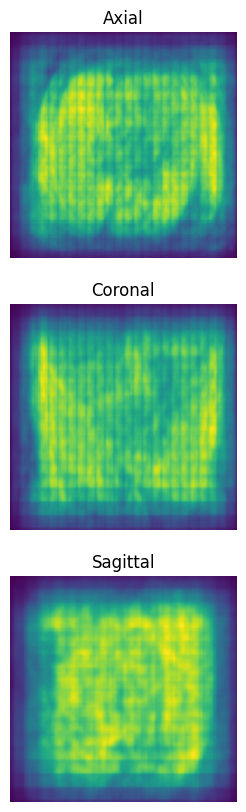

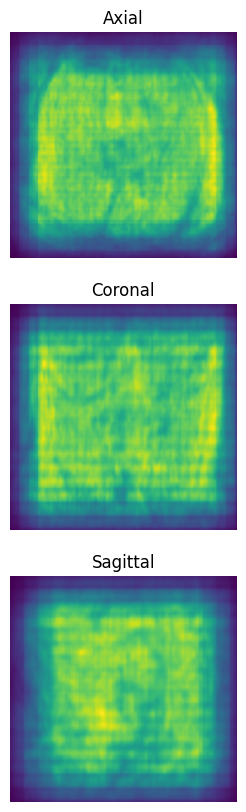

In [128]:
concept_map_pca = torch.tensor(concept_map_pca)
plot_3d_image(concept_map_pca[0, 0].unsqueeze(0))
plot_3d_image(concept_map_pca[0, 1].unsqueeze(0))



In [10]:
concept_map_pca[0, 0] *= -1


In [248]:
concept_map_pca_thresh = concept_map_pca.clone()
mask = concept_map_pca_thresh[0, :] > 12


concept_map_pca_thresh[0, :] = torch.where(mask, concept_map_pca_thresh[0,:], concept_map_pca_thresh[0,:].min())
concept_map_pca_thresh[1, :] = torch.where(mask, concept_map_pca_thresh[1,:], concept_map_pca_thresh[1,:].min())
concept_map_pca_thresh[2, :] = torch.where(mask, concept_map_pca_thresh[2,:], concept_map_pca_thresh[2,:].min())
concept_map_pca_thresh[3, :] = torch.where(mask, concept_map_pca_thresh[3,:], concept_map_pca_thresh[3,:].min())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-23.49895..29.353863].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-23.49895..30.126411].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-23.49895..23.574402].


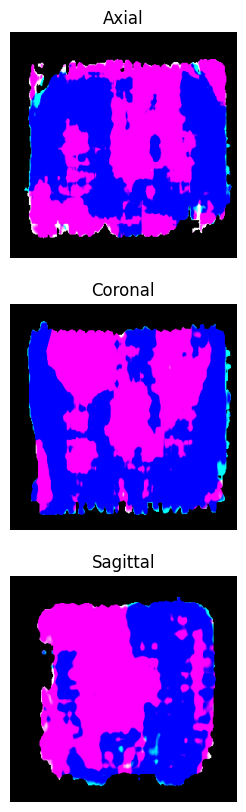

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-23.49895..23.14088].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-23.49895..23.244175].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-23.49895..22.281605].


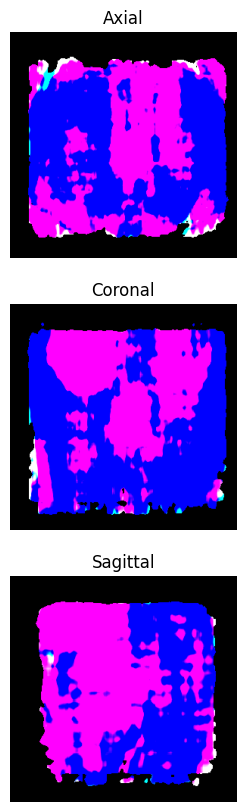

In [249]:
plot_3d_image(concept_map_pca_thresh[[2, 1, 0], 0])
plot_3d_image(concept_map_pca_thresh[[2, 1, 0], 1])

In [250]:
concept_map_pca_thresh[0, :] = (concept_map_pca_thresh[0, :] - concept_map_pca_thresh[0, :].min()) / (concept_map_pca_thresh[0, :].max() - concept_map_pca_thresh[0, :].min())
concept_map_pca_thresh[1, :] = (concept_map_pca_thresh[1, :] - concept_map_pca_thresh[1, :].min()) / (concept_map_pca_thresh[1, :].max() - concept_map_pca_thresh[1, :].min())
concept_map_pca_thresh[2, :] = (concept_map_pca_thresh[2, :] - concept_map_pca_thresh[2, :].min()) / (concept_map_pca_thresh[2, :].max() - concept_map_pca_thresh[2, :].min())
concept_map_pca_thresh[3, :] = (concept_map_pca_thresh[3, :] - concept_map_pca_thresh[3, :].min()) / (concept_map_pca_thresh[3, :].max() - concept_map_pca_thresh[3, :].min())

In [251]:
def normalize_with_exp(x, exp_factor=2.71828):
    # x = torch.pow(x, exp_factor)
    x_min = x.min()
    x_max = x.max()
    normalized = (x - x_min) / (x_max - x_min)
    return normalized

concept_map_pca_thresh[0, :] = normalize_with_exp(concept_map_pca_thresh[0, :])
concept_map_pca_thresh[1, :] = normalize_with_exp(concept_map_pca_thresh[1, :])
concept_map_pca_thresh[2, :] = normalize_with_exp(concept_map_pca_thresh[2, :])
concept_map_pca_thresh[3, :] = normalize_with_exp(concept_map_pca_thresh[3, :])

In [252]:
concept_map_pca_thresh.min(), concept_map_pca_thresh.max()

(tensor(0.), tensor(1.))

torch.Size([3, 300, 300, 300])
torch.Size([3, 300, 300, 300])


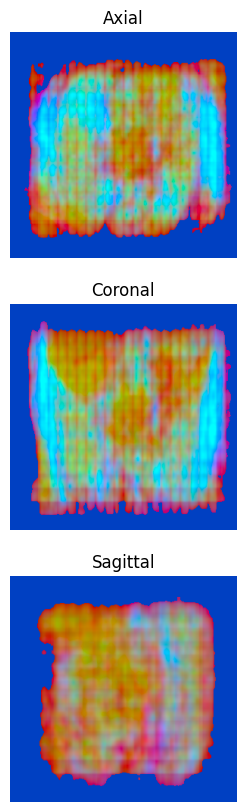

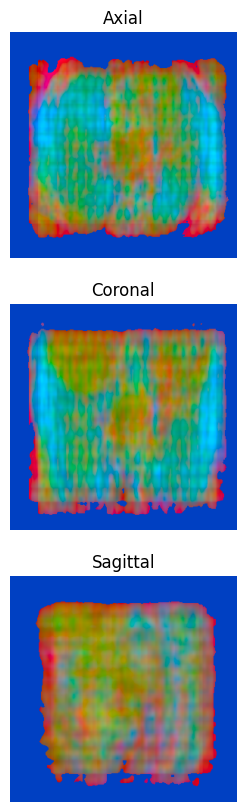

In [274]:
# Convert to LAB range
lab_range_0 = concept_map_pca_thresh[[0, 1, 2], 0].clone()
lab_range_1 = concept_map_pca_thresh[[0, 1, 2], 1].clone()


# L channel: [0, 100]
lab_range_0[0] = lab_range_0[0] * 100
lab_range_1[0] = lab_range_1[0] * 100

# a and b channels: [-128, 127]
lab_range_0[1:] = (lab_range_0[1:] * 255) - 128
lab_range_1[1:] = (lab_range_1[1:] * 255) - 128


lab_range_0 = lab_to_rgb(lab_range_0)
lab_range_1 = lab_to_rgb(lab_range_1)

print(lab_range_0.shape)

plot_3d_image(lab_range_0)
plot_3d_image(lab_range_1)

In [277]:
from platipy.imaging.visualisation.visualiser import ImageVisualiser
import SimpleITK as sitk
import numpy as np

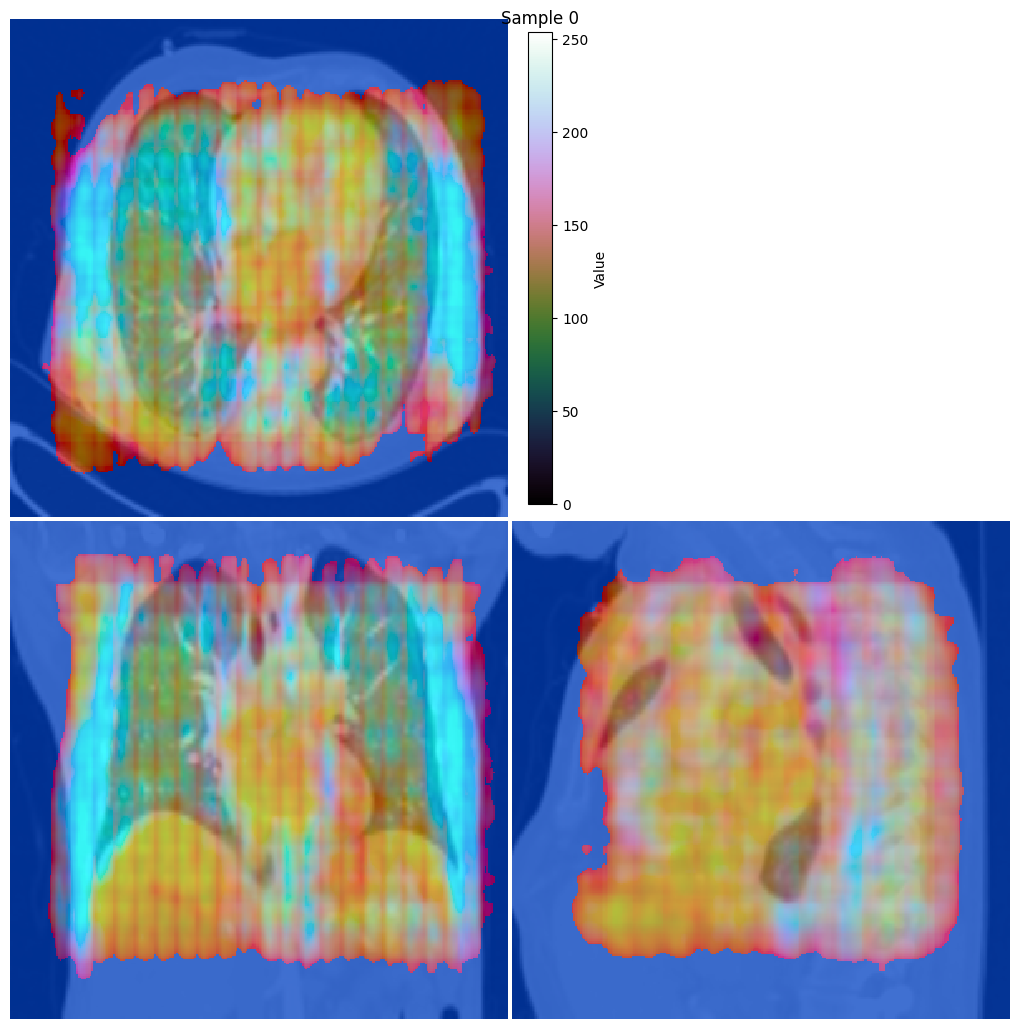

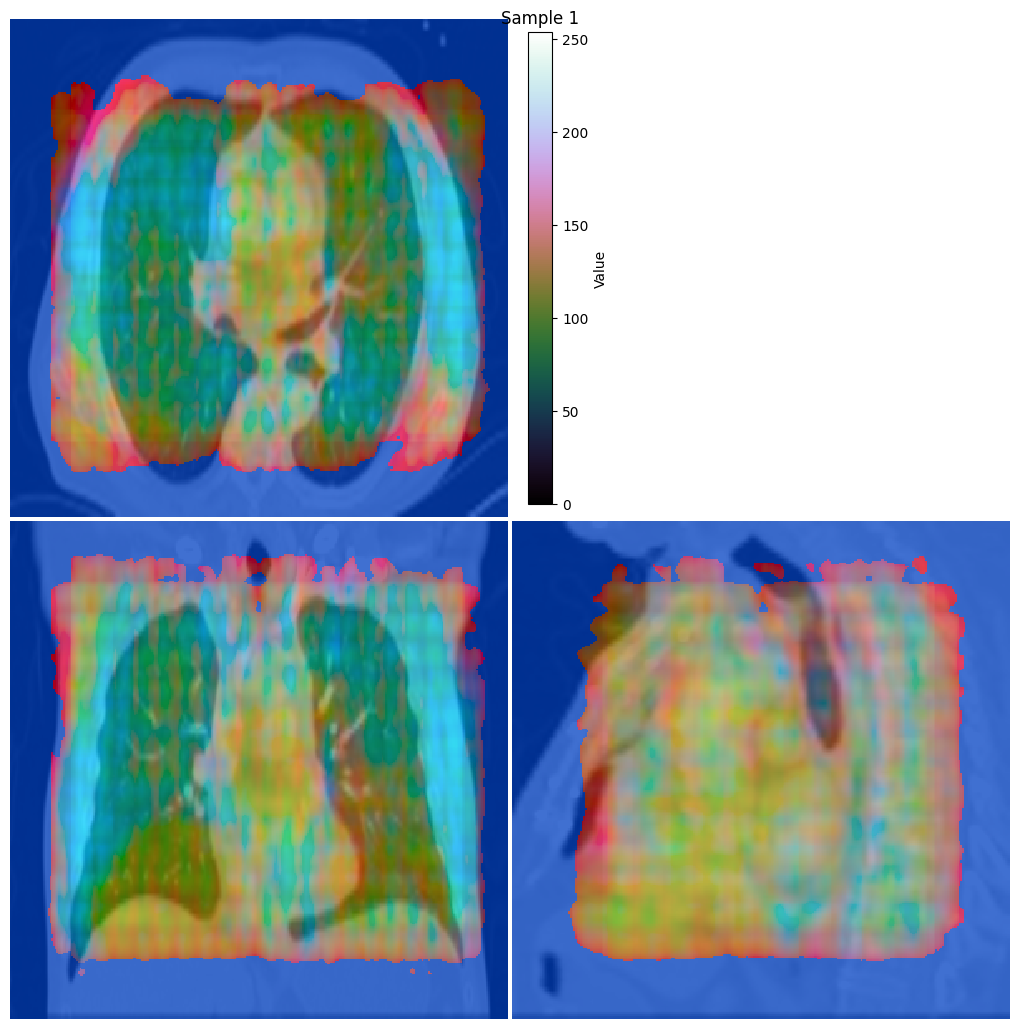

In [285]:
import torch
import torch.nn.functional as F

# Iterate over idx
for idx in range(len(image_dict_list)):
    # Interpolate image to 300x300x300 using PyTorch
    image_tensor = image_dict_list[idx]["image"].unsqueeze(0) # Add batch dimension
    new_size = (300, 300, 300)
    image_interpolated = F.interpolate(image_tensor, size=new_size, mode='trilinear', align_corners=False)
    image_interpolated = image_interpolated.squeeze()  # Remove batch dimension

    # Interpolate concept map to 300x300x300 using PyTorch

    # Convert to LAB range
    lab_range = concept_map_pca_thresh[[0, 1, 2], idx].clone()

    # L channel: [0, 100]
    lab_range[0] = lab_range[0] * 100

    # a and b channels: [-128, 127]
    lab_range[1:] = (lab_range[1:] * 255) - 128

    lab_range = lab_to_rgb(lab_range)
    concept_map_rgb = lab_range.unsqueeze(0)  # Add batch dimension
    # concept_map_interpolated = F.interpolate(concept_map_rgb, size=new_size, mode='nearest')
    concept_map_interpolated = concept_map_rgb.squeeze().permute(1, 2, 3, 0)  # Remove batch dimension
    concept_map_interpolated = (concept_map_interpolated * 255).byte()

    # Convert interpolated tensors to SimpleITK images
    image_sitk = sitk.GetImageFromArray(image_interpolated.numpy())
    concept_map_sitk = sitk.GetImageFromArray(concept_map_interpolated.numpy(), isVector=True)

    # # Set the same metadata for both images
    # for img in [image_sitk, concept_map_sitk]:
    #     img.SetOrigin((0, 0, 0))
    #     img.SetSpacing((1, 1, 1))
    #     img.SetDirection((1, 0, 0, 0, 1, 0, 0, 0, 1))

    viz = ImageVisualiser(image_sitk)
    import matplotlib.pyplot as plt

    viz.add_scalar_overlay(concept_map_sitk, alpha=0.75)
    fig = viz.show()
    plt.title(f"Sample {idx}")
    plt.show()